In [1]:
#steps
import sqlite3
import pandas as pd

# Import large Mt5 model
# bring in dataset
# Fine tune
# Evaluate

## Data Conversion

In [2]:
##Bring in dataset

from datasets import load_dataset

from transformers import MT5ForConditionalGeneration, Trainer, TrainingArguments

dataset = load_dataset("squad_es",'v1.1.0')

# Step 1 and 2: Combine context and question, format the answer
from transformers import T5TokenizerFast

# Load the tokenizer
tokenizer = T5TokenizerFast.from_pretrained('google/mt5-base')

Reusing dataset squad_es (/root/.cache/huggingface/datasets/squad_es/v1.1.0/1.1.0/bcada4f600192451443b95e24f609325705c5185b8aad97bffa8bc3784a867ad)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
dataset['train']['answers'][0]['text'][0]

'Santa Bernadette Soubirous'

In [ ]:

# Step 1 and 2: Combine context and question, format the answer
from transformers import T5TokenizerFast

# Load the tokenizer
tokenizer = T5TokenizerFast.from_pretrained('google/mt5-base')


def prep_data(train_subset):

    # Create new lists for our inputs and answers
    input_ids = []
    input_attn_msk = []
    answers_ids = []

    for id_value, title_value, context_value, q_value, a_value in zip(train_subset['id'], train_subset['title'], train_subset['context'],train_subset['question'],train_subset['answers']):

        #INPUTS
        # Combine the context and question into a single string
        input_str = context_value + " " + q_value
        #print(input_str)

        #tokenize the inputs
        inputs = tokenizer(input_str, truncation=True, padding='max_length', max_length=512)
        #print(inputs.input_ids)
        input_ids.append(inputs.input_ids)
        input_attn_msk.append(inputs.attention_mask)


        #ANSWERS
        answers = a_value['text'][0]
        answers_tokens = tokenizer(answers, truncation=True, padding='max_length', max_length=128)
        answers_ids.append(answers_tokens.input_ids)


    result_list = []


    # Iterate over the values from each list
    for input_id, attention_mask, label  in zip(input_ids, input_attn_msk, answers_ids):
        # Create a dictionary with the desired keys
        data_dict = {
            'input_ids': torch.tensor(input_id),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(label)

        }

        # Append the dictionary to the result list
        result_list.append(data_dict)

    return(result_list)


    


In [ ]:
import torch
# Start with a subset of your data for testing
train_subset = dataset['train'][:3000]  # Adjust this as needed

model_train_data = prep_data(train_subset)


# Start with a subset of your data for testing
val_subset = dataset['validation'][:500]  # Adjust this as needed

model_val_data = prep_data(val_subset)
          
          

## Data ready test

In [ ]:
# replace 'train_dataset' with your dataset variable
sample = model_train_data[0]

assert isinstance(sample, dict), "Each item in dataset must be a dictionary"
assert 'input_ids' in sample, "input_ids must be in the dataset"
assert 'attention_mask' in sample, "attention_mask must be in the dataset"
assert 'labels' in sample, "labels must be in the dataset"

print("Your dataset appears to be correctly structured for Trainer.")


Your dataset appears to be correctly structured for Trainer.


In [ ]:
# replace 'train_dataset' with your dataset variable
sample = model_val_data[0]

assert isinstance(sample, dict), "Each item in dataset must be a dictionary"
assert 'input_ids' in sample, "input_ids must be in the dataset"
assert 'attention_mask' in sample, "attention_mask must be in the dataset"
assert 'labels' in sample, "labels must be in the dataset"

print("Your dataset appears to be correctly structured for Trainer.")


Your dataset appears to be correctly structured for Trainer.


In [ ]:
print(model_val_data[0]['input_ids'].shape)
print(model_val_data[0]['attention_mask'].shape)
print(model_val_data[0]['labels'].shape)
                        

torch.Size([512])
torch.Size([512])
torch.Size([128])


## Fine Tuning

In [ ]:
from transformers import MT5ForConditionalGeneration, Trainer, TrainingArguments
import wandb

# Initialize the model
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-base")

wandb.init(project="mt5_fine_tune", name="training_run")

# Initialize the training arguments
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)



'''
training_args = TrainingArguments(
    output_dir='./results',  # output directory
    num_train_epochs=3,     # total number of training epochs
    per_device_train_batch_size=3,  # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    warmup_steps=500,       # number of warmup steps for learning rate scheduler
    weight_decay=0.01,      # strength of weight decay
    logging_dir='./logs',   # directory for storing logs
    logging_steps=10,       # when to print log
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps", # evaluation is done at every logging step
    load_best_model_at_end=True, # the best model is loaded at the end of training (might be slower with big datasets)
    metric_for_best_model="loss", # the metric to use to compare models
    run_name="run_name", # Wandb run name
)

'''


# Define the compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=model_train_data,            # training dataset
    eval_dataset=model_val_data,         # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# Train the model
#trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

wandb: Currently logged in as: jprivera44 (cs7643_jp). Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
#saving data to disk

import torch

# Save the model and training_args
#torch.save(model.state_dict(), 'model_input/model.pth')
model.save_pretrained('model_input/model')
torch.save(training_args, 'model_input/training_args.pth')

import pickle

with open('model_input/train_data.pkl', 'wb') as f:
    pickle.dump(model_train_data, f)

with open('model_input/val_data.pkl', 'wb') as f:
    pickle.dump(model_val_data, f)

# Here, compute_metrics is a function. You cannot save it directly, but you can define it in your script or import it from a shared Python module.


Configuration saved in model_input/model/config.json
Model weights saved in model_input/model/pytorch_model.bin


In [ ]:
!nsys profile --trace=cuda --stats=true -o report_mt5 --force-overwrite=true python3 Mt5-fine-tuning.py --model 'model_input/model' --training_args 'model_input/training_args.pth' --train_data_path 'model_input/train_data.pkl' --val_data_path 'model_input/val_data.pkl'




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2250
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logge

## Analyze CUDA

In [18]:
#Importing files

# Connecting the output sql file rom nsys
conn = sqlite3.connect('report_mt5.sqlite')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('StringIds',), ('ProcessStreams',), ('TARGET_INFO_SYSTEM_ENV',), ('TARGET_INFO_SESSION_START_TIME',), ('ANALYSIS_DETAILS',), ('PROCESSES',), ('PROFILER_OVERHEAD',), ('CUPTI_ACTIVITY_KIND_RUNTIME',), ('CUPTI_ACTIVITY_KIND_MEMCPY',), ('CUPTI_ACTIVITY_KIND_SYNCHRONIZATION',), ('CUPTI_ACTIVITY_KIND_KERNEL',), ('CUPTI_ACTIVITY_KIND_MEMSET',), ('ThreadNames',), ('TARGET_INFO_GPU',), ('TARGET_INFO_CUDA_NULL_STREAM',), ('TARGET_INFO_CUDA_STREAM',), ('EXPORT_META_DATA',)]


In [19]:
import sqlite3

def query_db(query):
    conn = sqlite3.connect('report_mt5.sqlite')
    cursor = conn.execute(query)
    result = cursor.fetchall()
    conn.close()
    return result

# Query GPU details
print(query_db("SELECT * FROM TARGET_INFO_GPU;"))

# Query Kernel execution details
#print(query_db("SELECT * FROM CUPTI_ACTIVITY_KIND_KERNEL;"))

# Query Memory copy/set operations details
#print(query_db("SELECT * FROM CUPTI_ACTIVITY_KIND_MEMCPY;"))
#print(query_db("SELECT * FROM CUPTI_ACTIVITY_KIND_MEMSET;"))


[(281474976710656, 0, 'NVIDIA RTX A6000', '0000:00:05.0', 1, 6291456, 51041271808, 768096000000, 1800000000, 84, 0, '082f4df2-ec32-4027-334d-5914b2d3d62e', 0, 'GA102', 0, '', '', 161, 0, 65536, 4, 65536, 49152, 101376, 102400, 65536, 32, 2, 48, 16, 1024, 1024, 1024, 64, 2147483647, 65535, 65535, 8, 6, 8, 6)]


In [20]:
# Connect to the SQLite database
conn = sqlite3.connect('report_mt5.sqlite')

# Run the query and load the results into a pandas DataFrame
query = "SELECT * FROM CUPTI_ACTIVITY_KIND_KERNEL"
df_kernel_data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()



In [ ]:
df_kernel_data

,start,end,deviceId,contextId,streamId,correlationId,globalPid,demangledName,shortName,mangledName,...,blockY,blockZ,staticSharedMemory,dynamicSharedMemory,localMemoryPerThread,localMemoryTotal,gridId,sharedMemoryExecuted,graphNodeId,sharedMemoryLimitConfig
0,14653005663,14653024765,0,1,7,3680,281489807769600,67,68,56,...,1,1,0,0,0,121110528,1,16384,None,0
1,14653276249,14653280824,0,1,7,3692,281489807769600,70,71,57,...,1,1,0,0,0,121110528,2,16384,None,0
2,14653423909,14653426244,0,1,7,3701,281489807769600,72,73,58,...,1,1,0,0,0,121110528,3,16384,None,0
3,14653509721,14653512216,0,1,7,3709,281489807769600,74,73,59,...,1,1,0,0,0,121110528,4,16384,None,0
4,14653721787,14653745240,0,1,7,3731,281489807769600,75,76,60,...,1,1,0,0,0,121110528,5,8192,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521391,41566418470,41566429445,0,1,7,5107211,281489807769600,170,73,114,...,1,1,0,0,0,121110528,527392,16384,None,0
521392,41566430181,41566440932,0,1,7,5107218,281489807769600,170,73,114,...,1,1,0,0,0,121110528,527393,16384,None,0
521393,41566441603,41566443875,0,1,7,5107225,281489807769600,170,73,114,...,1,1,0,0,0,121110528,527394,16384,None,0
521394,41566444515,41566446594,0,1,7,5107232,281489807769600,170,73,114,...,1,1,0,0,0,121110528,527395,16384,None,0


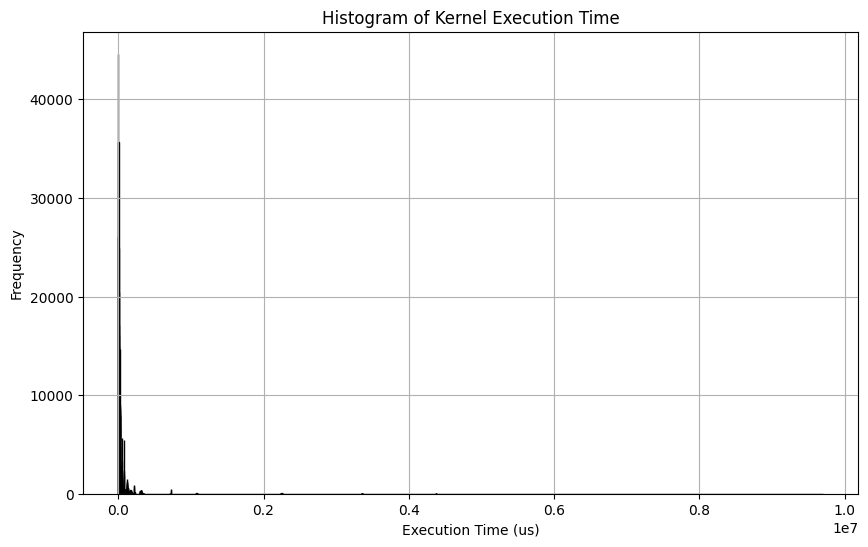

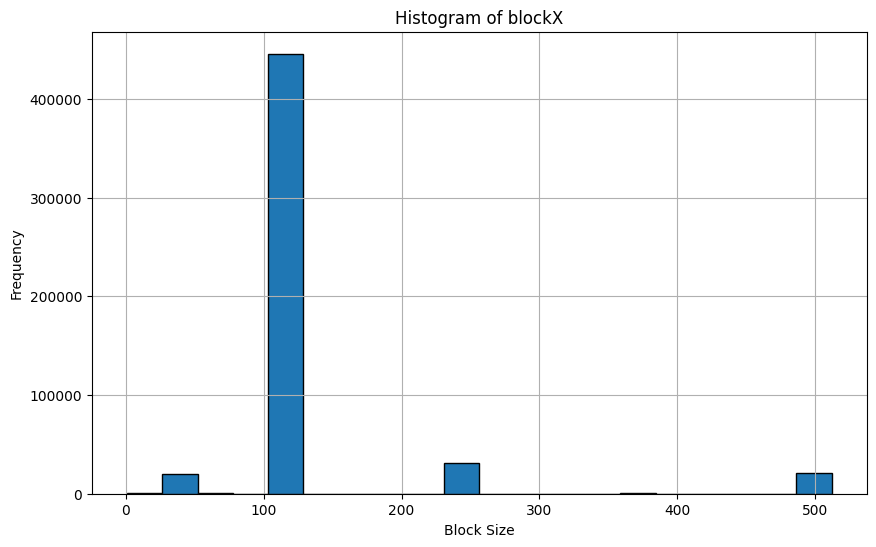

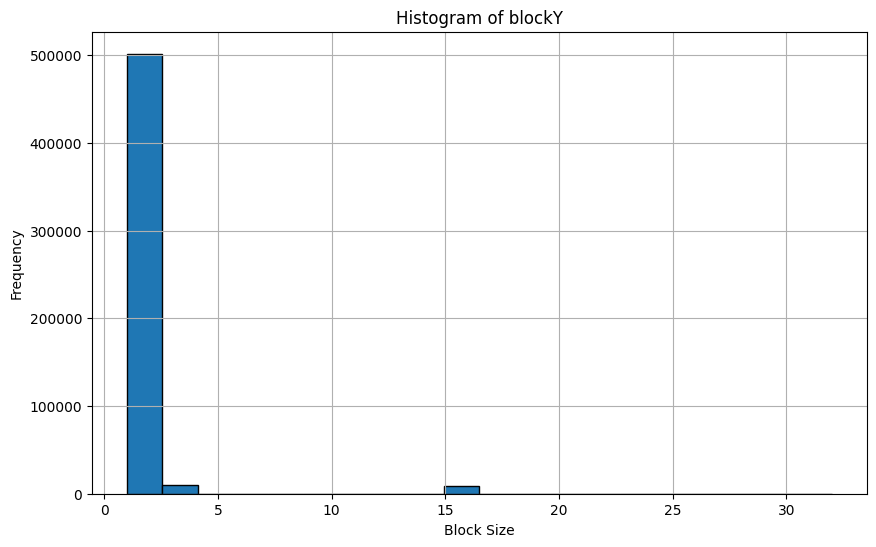

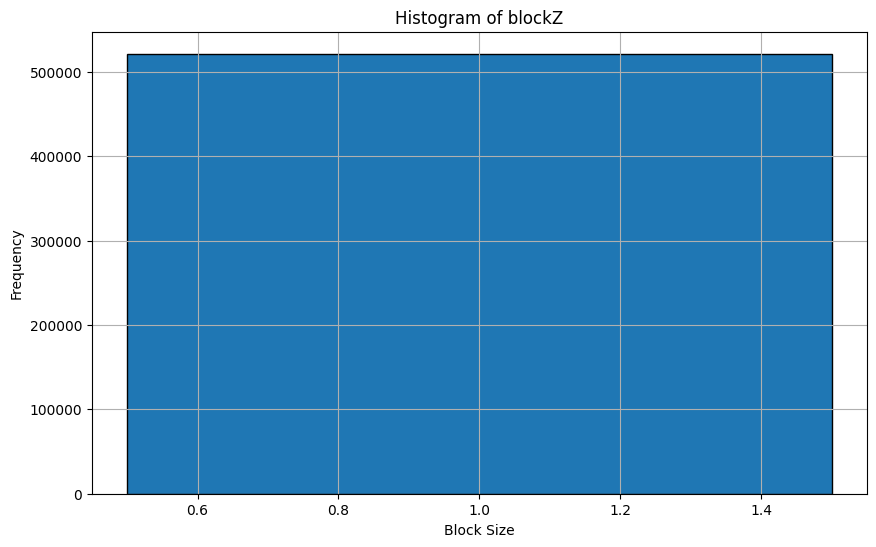

In [21]:
import matplotlib.pyplot as plt

# Calculate the execution time for each kernel in microseconds
df_kernel_data['execution_time_us'] = df_kernel_data['end'] - df_kernel_data['start']

# Define a function to create a histogram
def plot_histogram(data, title, xlabel, ylabel, bins='auto'):
    plt.figure(figsize=(10,6))
    plt.hist(data, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Plot a histogram of the kernel execution times
plot_histogram(df_kernel_data['execution_time_us'], 
               'Histogram of Kernel Execution Time', 
               'Execution Time (us)', 
               'Frequency')


# Analyzing block size
block_columns = ['blockX', 'blockY', 'blockZ']
for col in block_columns:
    plot_histogram(df_kernel_data[col], 
                   f'Histogram of {col}', 
                   'Block Size', 
                   'Frequency')


In [ ]:
df_kernel_data.to_csv('kernel_activity.csv', index=False)
